# Comparison of Methods for Setting Values in Pandas DataFrames
What is the fastet method for setting values in a Pandas DataFrame? Here the following methods are compared:
- Pandas `iloc`
- Pandas `iat`
- Setting DataFrame's `values` NumPy array directly
- Converting DataFrame to a `dict` and then setting values

The test is to set the maximum number of values (i.e. all values) in single-column DataFrames of increasingly large sizes $2^n$ where $n=5,\cdots,21$. The original data and the data used for setting are both type `float64`. The data used for setting is generated by `np.random.normal`. The timeit library is used for profiling, each test is repeated 5 times and the average time is used for comparison.

Note, that Pandas `ix` function is not tested here as it is deprecated from version 0.20.0.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 1.3.3
NumPy version: 1.20.3


In [2]:
# Dictionary for Results:
results = {
    'iloc' : {}, 
    'iat' : {},
    'np' : {},
    'dict' : {},
    'dict_alt' : {}
}

In [3]:
# Test Function Definitions:
def iloc_set(df, rows, test_set_data):
    """Sets values using iloc."""
    for i in range(rows):
        df.iloc[i] = test_set_data[i]
    return df
    
def iat_set(df, rows, test_set_data):
    """Sets values using iat."""
    for i in range(rows):
        df.iat[i, 0] = test_set_data[i]
    return df

def np_set(df, rows, test_set_data):
    """Sets values using pd.DataFrame.values which is an numpy.ndarray."""
    for i in range(rows):
        df.values[i] = test_set_data[i]
    return df

def dict_set(df, test_set_data):
    """
    Sets values by converting DataFrame to a dict, iterating through its 
    keys, then converting back to a DataFrame.
    """
    df_dict = df.to_dict()
    for k in df_dict[0].keys():
        df_dict[0][k] = test_set_data[k]
    df = pd.DataFrame(df_dict)
    return df

def dict_alt_set(df, rows, test_set_data):
    """
    Sets values by converting DataFrame to a dict, iterating through a specified 
    range, then converting back to a DataFrame.
    """
    df_dict = df.to_dict()
    for i in range(rows):
        df_dict[0][i] = test_set_data[i]
    df = pd.DataFrame(df_dict)
    return df

In [4]:
# Collect Data:
n_rows = []
for n in range(5, 22):
    print(f"Collecting data for array size 2^{n}...")

    # Get Test Data:
    rows = 2**n
    n_rows.append(rows)
    test_set_data = np.random.normal(0, 1, rows)
    test_original_data = np.zeros(rows)

    # Test iloc method:
    df = pd.DataFrame(test_original_data, copy=True)
    iloc_result = %timeit -q -n1 -o iloc_set(df, rows, test_set_data)
    results['iloc'][rows] = iloc_result

    # Test iat method:
    df = pd.DataFrame(test_original_data, copy=True)
    iat_result = %timeit -q -n1 -o iat_set(df, rows, test_set_data)
    results['iat'][rows] = iat_result

    # Test np method:
    df = pd.DataFrame(test_original_data, copy=True)
    np_result = %timeit -q -n1 -o np_set(df, rows, test_set_data)
    results['np'][rows] = np_result

    # Test dict method:
    df = pd.DataFrame(test_original_data, copy=True)
    dict_result = %timeit -q -n1 -o dict_set(df, test_set_data)
    results['dict'][rows] = dict_result

    # Test dict method for custom range:
    df = pd.DataFrame(test_original_data, copy=True)
    dict_alt_result = %timeit -q -n1 -o dict_alt_set(df, rows, test_set_data)
    results['dict_alt'][rows] = dict_alt_result

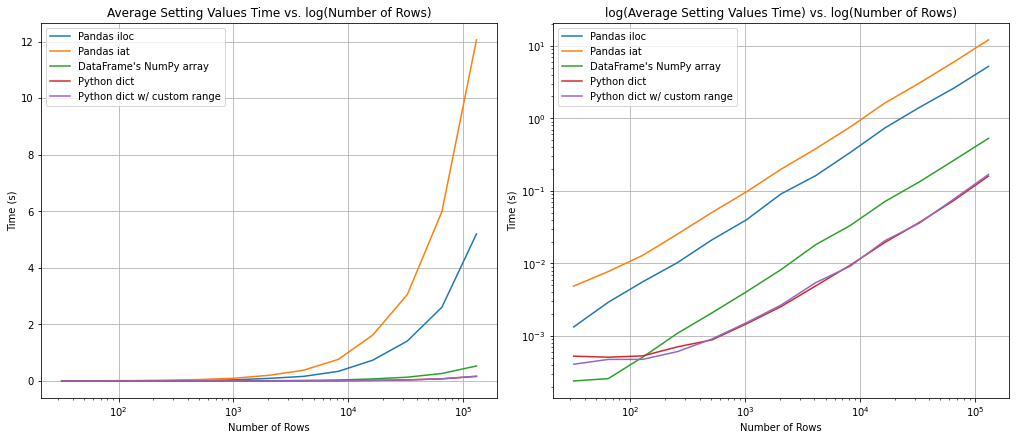

In [ ]:
# Figure, Axes:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), constrained_layout=True)

# Plot Time vs. log(Rows):
ax[0].plot(n_rows, [results['iloc'][rows].average for rows in n_rows], label=u'Pandas iloc')
ax[0].plot(n_rows, [results['iat'][rows].average for rows in n_rows], label='Pandas iat')
ax[0].plot(n_rows, [results['np'][rows].average for rows in n_rows], label='DataFrame\'s NumPy array')
ax[0].plot(n_rows, [results['dict'][rows].average for rows in n_rows], label='Python dict')
ax[0].plot(n_rows, [results['dict_alt'][rows].average for rows in n_rows], label='Python dict w/ custom range')
ax[0].set_xlabel('Number of Rows')
ax[0].set_ylabel('Time (s)')
ax[0].set_xscale('log')
ax[0].grid()
ax[0].legend()
ax[0].set_title('Average Setting Values Time vs. log(Number of Rows)')

# Plot log(Time) vs. log(Rows):
ax[1].plot(n_rows, [results['iloc'][rows].average for rows in n_rows], label='Pandas iloc')
ax[1].plot(n_rows, [results['iat'][rows].average for rows in n_rows], label='Pandas iat')
ax[1].plot(n_rows, [results['np'][rows].average for rows in n_rows], label='DataFrame\'s NumPy array')
ax[1].plot(n_rows, [results['dict'][rows].average for rows in n_rows], label='Python dict')
ax[1].plot(n_rows, [results['dict_alt'][rows].average for rows in n_rows], label='Python dict w/ custom range')
ax[1].set_xlabel('Number of Rows')
ax[1].set_ylabel('Time (s)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()
ax[1].set_title('log(Average Setting Values Time) vs. log(Number of Rows)')

# Show Plot:
plt.show()

## Remarks
Pandas own `iloc` and `iat` function are the worst performers. The `iloc` method is quicker as it only operates on a single axis, whereas `iat` takes both row and column indexes. 

Accessing and setting on the NumPy array in the DataFrame is best for smaller DataFrames ($\leq 10^2$ rows). However, in most cases converting the DataFrame to a Python `dict`, using the `to_dict` method, and setting values on this `dict` is the fastest. Dictionaries in Python are highly optimized (further improved since Python 3.6, see https://www.python.org/dev/peps/pep-0468/#compact-dict-with-faster-iteration) and setting values will be between $\mathcal{O} (1)$ and $\mathcal{O} (n)$ (see https://wiki.python.org/moin/TimeComplexity). 

While only one-dimensional DataFrames are tested here, these results should still be valid for two-dimensional DataFrames as *all* functions above would require an additional, nested, `for` loop to iterate through the extra dimension.

Note, the `dict_alt_set` function above is used to demonstrate how the dictionary approach could be used for a custom index range, showing that it performs the same as the vanilla dictionary function. 